In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from nltk.corpus import gutenberg, stopwords
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Background 

First, pick a set of texts. This can be either a series of novels, chapters, or articles. Anything you'd like. It just has to have multiple entries of varying characteristics. At least 100 should be good. There should also be at least 10 different authors, but try to keep the texts related (either all on the same topic of from the same branch of literature - something to make classification a bit more difficult than obviously different subjects).

In [2]:
# Lets look at what text I can use. 
gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [3]:
# Pick 10 different books with 10 different authors.
austen = gutenberg.raw('austen-emma.txt')
bible = gutenberg.raw('bible-kjv.txt')
blake = gutenberg.raw('blake-poems.txt')
bryant = gutenberg.raw('bryant-stories.txt')
buster = gutenberg.raw('burgess-busterbrown.txt')
chesterton = gutenberg.raw('chesterton-thursday.txt')
edgeworth = gutenberg.raw('edgeworth-parents.txt')
milton = gutenberg.raw('milton-paradise.txt')
shakes = gutenberg.raw('shakespeare-caesar.txt')
whitman = gutenberg.raw('whitman-leaves.txt')

# Data Cleaning 

In [4]:
# Utility function to clean text.
def text_cleaner(text):
    
    # Visual inspection shows spaCy does not recognize the double dash '--'.
    # Better get rid of it now!
    text = re.sub(r'--',' ',text)
    
    # Get rid of headings in square brackets.
    text = re.sub("[\[].*?[\]]", "", text)
    
    # Get rid of chapter titles.
    text = re.sub(r'Chapter \d+','',text)
    text = re.sub(r'CHAPTER \d+', '', text)
    text = re.sub("\\n\\n.*?\\n\\n", '', text)
  
    # Get rid of extra whitespace.
    text = ' '.join(text.split())

    
    return text

In [20]:
# Clean documents
austen = text_cleaner(austen)[:100000]
# Bible was over the limit for nlp so I had to limit it.
bible = text_cleaner(bible)[:100000]
blake = text_cleaner(blake)[:100000]
bryant = text_cleaner(bryant)[:100000]
buster = text_cleaner(buster)[:100000]
chesterton = text_cleaner(chesterton)[:100000]
edgeworth = text_cleaner(edgeworth)[:100000]
milton = text_cleaner(milton)[:100000]
shakes = text_cleaner(shakes)[:100000]
whitman = text_cleaner(whitman)[:100000]

In [21]:
books = [austen, bible, blake, bryant, buster, buster, chesterton,
edgeworth, milton, shakes, whitman]

for i in books:
    print(len(i))

100000
99989
35855
100000
82085
82085
100000
100000
100000
100000
100000


In [22]:
# run spaCy and analyze the documents
nlp = spacy.load('en')


austen_doc = nlp(austen)
bible_doc = nlp(bible)
blake_doc = nlp(blake)
bryant_doc = nlp(bryant)
buster_doc = nlp(buster)
chesterton_doc = nlp(chesterton)
edgeworth_doc = nlp(edgeworth)
milton_doc = nlp(milton)
shakes_doc = nlp(shakes)
whitman_doc = nlp(whitman)

In [23]:
# Group into sentences
austen_sents = [[sent, 'austen'] for sent in austen_doc.sents]
bible_sents = [[sent, 'bible'] for sent in bible_doc.sents]
blake_sents = [[sent, 'blake'] for sent in blake_doc.sents]
bryant_sents = [[sent, 'bryant'] for sent in bryant_doc.sents]
buster_sents = [[sent, 'buster'] for sent in buster_doc.sents]
chesterton_sents = [[sent, 'chesterton'] for sent in chesterton_doc.sents]
edgeworth_sents = [[sent, 'edgeworth'] for sent in edgeworth_doc.sents]
milton_sents = [[sent, 'milton'] for sent in milton_doc.sents]
shakes_sents = [[sent, 'shakes'] for sent in shakes_doc.sents]
whitman_sents = [[sent, 'whitman'] for sent in whitman_doc.sents]

In [27]:
# Utility function to create a list of the 1500 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(1500)]
    

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

# Set up the bags.
austen_words = bag_of_words(austen_doc)
bible_words = bag_of_words(bible_doc)
blake_words = bag_of_words(blake_doc)
bryant_words = bag_of_words(bryant_doc)
buster_words = bag_of_words(buster_doc)
chesterton_words = bag_of_words(chesterton_doc)
edgeworth_words = bag_of_words(edgeworth_doc)
milton_words = bag_of_words(milton_doc)
shakes_words = bag_of_words(shakes_doc)
whitman_words = bag_of_words(whitman_doc)

# Combine bags to create a set of unique words.
common_words = set(austen_words + bible_words + blake_words + bryant_words +
                        buster_words + chesterton_words + edgeworth_words +
                        milton_words + shakes_words + whitman_words)

# How many words we got?
len(common_words)

7196

In [28]:
# Combine the sentences from the 10 novels into one data frame.
sentences = pd.DataFrame(austen_sents + bible_sents + blake_sents + bryant_sents +
                        buster_sents + chesterton_sents + edgeworth_sents +
                        milton_sents + shakes_sents + whitman_sents)

In [29]:
# Create our data frame with features. This can take a while to run.
word_counts = bow_features(sentences, common_words)
word_counts.head()

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000
Processing row 3500
Processing row 4000
Processing row 4500
Processing row 5000
Processing row 5500
Processing row 6000
Processing row 6500
Processing row 7000
Processing row 7500
Processing row 8000
Processing row 8500
Processing row 9000
Processing row 9500
Processing row 10000


,feature,atelier,wanderer,casteth,flannel,bonnet,number,some,cost,fetch,...,pillow,covering,nest,loue,cheerfulness,gogol,emins,weep,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(CHAPTER, I, Emma, Woodhouse, ,, handsome, ,, ...",austen
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(She, was, the, youngest, of, the, two, daught...",austen
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Her, mother, had, died, too, long, ago, for, ...",austen
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Sixteen, years, had, Miss, Taylor, been, in, ...",austen
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Between, _, them)",austen


Due to the fact that my models have been performing poorly, I decided to add the bag of words and common words features in order to see if I can obtain stronger results.

# Tf-idf Vectorization

In [34]:
# Create the tf-idf function
def document_freq(data, sentences, common_words, doc_names, doc_words):
    
    # initialize df
    df = pd.DataFrame(columns = common_words)
    df.iloc[:, 0] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    df.loc[:, common_words] = 0
    df.rename(index={0:'df', 1:'cf', 2:'idf', 3:'austen', 4:'bible', 5:'blake',
                                                  6:'bryant', 7:'buster', 8:'chesterton',
                                                  9:'edgeworth', 10:'milton', 11:'shakes',
                                                  12:'whitman'}, inplace=True)
    
    for word in common_words:
        # find document frequency & collection frequency
        df.loc['df', word] = data[data[word] > 0][word].count()
        df.loc['cf', word] = data.loc[:, word].sum()
        
        # find idf
        df.loc['idf', word] = np.log2(len(sentences)/df.loc['df', word])
        
    # assign the idf value to the documents
    for word in df.columns:
        for i in range(len(doc_names)):
            if word in doc_words[i]:
                df.loc[doc_names[i], word] = df.loc['idf', word]
        
    return df

In [46]:
# Create arrays to identify and hold my words.
doc_names = ['austen', 'bible', 'blake', 'bryant', 'buster',
            'chesterton', 'edgeworth', 'milton', 'shakes', 'whitman']
doc_words = [austen_words, bible_words, blake_words, bryant_words, buster_words, chesterton_words,
            edgeworth_words, milton_words, shakes_words, whitman_words]
tf_idf = document_freq(word_counts, sentences, common_words, doc_names, doc_words)
tf_idf

,feature,atelier,wanderer,casteth,flannel,bonnet,number,some,cost,fetch,...,brunswick,yesterday,pillow,covering,nest,loue,cheerfulness,gogol,emins,weep
df,7.000000,1.000000,2.000000,1.000000,1.000000,3.000000,23.000000,21.00000,2.000000,15.000000,...,2.000000,4.000000,2.000000,2.000000,11.000000,34.000000,3.000000,7.000000,1.000000,38.00000
cf,7.000000,1.000000,2.000000,1.000000,1.000000,3.000000,25.000000,21.00000,2.000000,15.000000,...,2.000000,4.000000,2.000000,2.000000,11.000000,34.000000,3.000000,7.000000,1.000000,43.00000
idf,10.518513,13.325868,12.325868,13.325868,13.325868,11.740905,8.802306,8.93355,12.325868,9.418977,...,12.325868,11.325868,12.325868,12.325868,9.866436,8.238405,11.740905,10.518513,13.325868,8.07794
austen,10.518513,0.000000,0.000000,0.000000,0.000000,0.000000,8.802306,8.93355,0.000000,0.000000,...,12.325868,0.000000,0.000000,0.000000,0.000000,0.000000,11.740905,0.000000,0.000000,0.00000
bible,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.802306,0.00000,0.000000,9.418977,...,0.000000,0.000000,0.000000,12.325868,0.000000,0.000000,0.000000,0.000000,13.325868,8.07794
blake,0.000000,0.000000,12.325868,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,9.866436,0.000000,0.000000,0.000000,0.000000,8.07794
bryant,0.000000,0.000000,0.000000,13.325868,0.000000,11.740905,8.802306,8.93355,0.000000,9.418977,...,0.000000,0.000000,12.325868,0.000000,9.866436,0.000000,0.000000,0.000000,0.000000,0.00000
buster,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.802306,0.00000,0.000000,0.000000,...,0.000000,11.325868,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
chesterton,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.93355,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.518513,0.000000,0.00000
edgeworth,0.000000,0.000000,0.000000,0.000000,13.325868,0.000000,8.802306,8.93355,12.325868,9.418977,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.740905,0.000000,0.000000,0.00000


In [47]:
# Let's make it so that the rows become the columns.
tf_idf = tf_idf.T
tf_idf.head()

,df,cf,idf,austen,bible,blake,bryant,buster,chesterton,edgeworth,milton,shakes,whitman
feature,7.0,7.0,10.518513,10.518513,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
atelier,1.0,1.0,13.325868,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,13.325868
wanderer,2.0,2.0,12.325868,0.000000,0.0,12.325868,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
casteth,1.0,1.0,13.325868,0.000000,0.0,0.000000,13.325868,0.0,0.0,0.000000,0.0,0.0,0.000000
flannel,1.0,1.0,13.325868,0.000000,0.0,0.000000,0.000000,0.0,0.0,13.325868,0.0,0.0,0.000000


In [48]:
# Set up a threshold to count and see which word belongs where.
threshold = 13
tf_idf['austen_threshold'] = 0
tf_idf['bible_threshold'] = 0
tf_idf['blake_threshold'] = 0
tf_idf['bryant_threshold'] = 0
tf_idf['buster_threshold'] = 0
tf_idf['chesterton_threshold'] = 0
tf_idf['edgeworth_threshold'] = 0
tf_idf['milton_threshold'] = 0
tf_idf['shakes_threshold'] = 0



tf_idf['austen_threshold'] = np.where(tf_idf['austen'] > threshold, 1, 0)
tf_idf['bible_threshold'] = np.where(tf_idf['bible'] > threshold, 1, 0)
tf_idf['blake_threshold'] = np.where(tf_idf['blake'] > threshold, 1, 0)
tf_idf['bryant_threshold'] = np.where(tf_idf['bryant'] > threshold, 1, 0)
tf_idf['buster_threshold'] = np.where(tf_idf['buster'] > threshold, 1, 0)
tf_idf['chesterton_threshold'] = np.where(tf_idf['chesterton'] > threshold, 1, 0)
tf_idf['edgeworth_threshold'] = np.where(tf_idf['edgeworth'] > threshold, 1, 0)
tf_idf['milton_threshold'] = np.where(tf_idf['milton'] > threshold, 1, 0)
tf_idf['shakes_threshold'] = np.where(tf_idf['shakes'] > threshold, 1, 0)
tf_idf.head()

,df,cf,idf,austen,bible,blake,bryant,buster,chesterton,edgeworth,...,whitman,austen_threshold,bible_threshold,blake_threshold,bryant_threshold,buster_threshold,chesterton_threshold,edgeworth_threshold,milton_threshold,shakes_threshold
feature,7.0,7.0,10.518513,10.518513,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0,0,0,0,0,0,0,0,0
atelier,1.0,1.0,13.325868,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,13.325868,0,0,0,0,0,0,0,0,0
wanderer,2.0,2.0,12.325868,0.000000,0.0,12.325868,0.000000,0.0,0.0,0.000000,...,0.000000,0,0,0,0,0,0,0,0,0
casteth,1.0,1.0,13.325868,0.000000,0.0,0.000000,13.325868,0.0,0.0,0.000000,...,0.000000,0,0,0,1,0,0,0,0,0
flannel,1.0,1.0,13.325868,0.000000,0.0,0.000000,0.000000,0.0,0.0,13.325868,...,0.000000,0,0,0,0,0,0,1,0,0


In [49]:
# Set up a way to determine which word goes into which group.
# default with both
tf_idf['source'] = 'multiple'

# Create a method
def determine_who(df):
    # Create a loop that iterates through each row and determines where it goes.
    for i in range(len(df)):
        # make a counter
        flag = 0
        source = 'multiple'
        
        if (df.iloc[i, 13] == 1):
            flag = 1
            source = 'austen'
            
        if (df.iloc[i, 14] == 1):
            if (flag == 1):
                continue
            flag = 1
            source = 'bible'
            
        if (df.iloc[i, 15] == 1):
            if (flag == 1):
                continue
            flag = 1
            source = 'blake'
            
        if (df.iloc[i, 16] == 1):
            if (flag == 1):
                continue
            flag = 1
            source = 'bryant'
            
        if (df.iloc[i, 17] == 1):
            if (flag == 1):
                continue
            flag = 1
            source = 'buster'
            
        if (df.iloc[i, 18] == 1):
            if (flag == 1):
                continue
            flag = 1
            source = 'chesterton'
            
        if (df.iloc[i, 19] == 1):
            if (flag == 1):
                continue
            flag = 1
            source = 'edgeworth'
            
        if (df.iloc[i, 20] == 1):
            if (flag == 1):
                continue
            flag = 1
            source = 'milton'
            
        if (df.iloc[i, 21] == 1):
            if (flag == 1):
                continue
            flag = 1
            source = 'shakes'
            
            
        df.iloc[i, 22] = source
        
    return df

In [51]:
# Was testing the output and accidentally created another row. 
tf_idf_final = determine_who(tf_idf)

tf_idf_final.head(30)

,df,cf,idf,austen,bible,blake,bryant,buster,chesterton,edgeworth,...,austen_threshold,bible_threshold,blake_threshold,bryant_threshold,buster_threshold,chesterton_threshold,edgeworth_threshold,milton_threshold,shakes_threshold,source
feature,7.0,7.0,10.518513,10.518513,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,multiple
atelier,1.0,1.0,13.325868,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,multiple
wanderer,2.0,2.0,12.325868,0.000000,0.000000,12.325868,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,multiple
casteth,1.0,1.0,13.325868,0.000000,0.000000,0.000000,13.325868,0.000000,0.000000,0.000000,...,0,0,0,1,0,0,0,0,0,bryant
flannel,1.0,1.0,13.325868,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.325868,...,0,0,0,0,0,0,1,0,0,edgeworth
bonnet,3.0,3.0,11.740905,0.000000,0.000000,0.000000,11.740905,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,multiple
number,23.0,25.0,8.802306,8.802306,8.802306,0.000000,8.802306,8.802306,0.000000,8.802306,...,0,0,0,0,0,0,0,0,0,multiple
some,21.0,21.0,8.933550,8.933550,0.000000,0.000000,8.933550,0.000000,8.933550,8.933550,...,0,0,0,0,0,0,0,0,0,multiple
cost,2.0,2.0,12.325868,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.325868,...,0,0,0,0,0,0,0,0,0,multiple
fetch,15.0,15.0,9.418977,0.000000,9.418977,0.000000,9.418977,0.000000,0.000000,9.418977,...,0,0,0,0,0,0,0,0,0,multiple


In [52]:
# Create a training and testing model 
Y = tf_idf_final['source']
X = tf_idf_final[['df', 'cf', 'idf']]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.25)


# Clustering

The point of using clusters is to group the paragraphs together to see if the clusters group accordingly to their author. There will be several different clustering techniques, the first being

## K-Means Clustering

K-means clustering is an iterative algorithm that seeks to cluster based on minimizing the inertia (cost function) or the sum of squared differences between the mean of the cluster and the data points of the cluster. 

Normally, the data would have to be normalized before using K-Means so that the distance would be accurate but that has already been done up top. 

In [53]:
from sklearn.cluster import KMeans

# I will use 10 clusters because I have 10 authors.
# Initialize the model. 
kmeans = KMeans(n_clusters=10, init='k-means++', random_state=42, n_init=20)

# Fit and predict the model. 
y_pred = kmeans.fit_predict(X_train)

pd.crosstab(y_train, y_pred)

col_0,0,1,2,3,4,5,6,7,8,9
source,,,,,,,,,,
austen,0,0,0,162,0,0,0,0,0,0
bible,0,0,0,464,0,0,0,0,0,0
blake,0,0,0,130,0,0,0,0,0,0
bryant,0,0,0,128,0,0,0,0,0,0
buster,0,0,0,87,0,0,0,0,0,0
chesterton,0,0,0,102,0,0,0,0,0,0
edgeworth,0,0,0,108,0,0,0,0,0,0
milton,0,0,0,32,0,0,0,0,0,0
multiple,278,1,9,2696,1,34,54,4,834,103


In [55]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score
# Evaluate the performance of the clusters

print('Adjusted Rand Score: {:0.7}'.format(adjusted_rand_score(y_train, y_pred)))
print('Silhouette Score: {:0.7}'.format(silhouette_score(X_train, y_pred, metric='euclidean')))

Adjusted Rand Score: -0.2043194
Silhouette Score: 0.7133754


Adjusted Rand Index is a function that measures the similarity of two assignments, ignoring permutations and with chance normalization. The score was negative which means that the similarity might as well be random. ARI has an accurate ground truth in the y-pred so it signals that the similarity isn't there.

Silhouette Coefficient is the mean distance between a sample and all other points in the same class (a), the mean distance between a sample and all other points in the next nearest cluster (b), divided by whichever of the two values is highest. Scores around 0 indicate overlapping clusters. Score is higher when clusters are dense and well separated. 

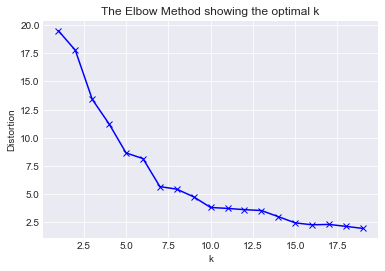

In [56]:
from scipy.spatial.distance import cdist
# Use the elbow method to see what is the optimal amount of clusters.

# k means determine k
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_train)
    kmeanModel.fit(X_train)
    distortions.append(sum(np.min(cdist(X_train, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_train.shape[0])

# Plot the elbow
sns.set_style('darkgrid')
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The elbow is actually around 6 clusters but I have to use 10 in order to see if the models can label the 10 authors. 

## Mini Batch K Means 

Mini Batch won't really change much since it is only used when PCA isn't run to reduce dimensionality and search for clusters in the reduced data. Mini Batch is useful if I want to keep all the data and if I have limited computational power or time. It works by randomly sampling subsets of the training data in each iteration. 

In [57]:
from sklearn.cluster import MiniBatchKMeans

# Initialize the model. 
minikmeans = MiniBatchKMeans(n_clusters=10, init='k-means++', random_state=42, init_size=1000, batch_size=1000)

# Predict and fit the model. 
y_pred2 = minikmeans.fit_predict(X_train)

pd.crosstab(y_train, y_pred2)

col_0,0,1,2,3,4,5,6,7,8,9
source,,,,,,,,,,
austen,162,0,0,0,0,0,0,0,0,0
bible,464,0,0,0,0,0,0,0,0,0
blake,130,0,0,0,0,0,0,0,0,0
bryant,128,0,0,0,0,0,0,0,0,0
buster,87,0,0,0,0,0,0,0,0,0
chesterton,102,0,0,0,0,0,0,0,0,0
edgeworth,108,0,0,0,0,0,0,0,0,0
milton,32,0,0,0,0,0,0,0,0,0
multiple,2530,28,141,2,43,26,341,77,10,816


In [58]:
print('Adjusted Rand Score: {:0.7}'.format(adjusted_rand_score(y_train, y_pred2)))
print('Silhouette Score: {:0.7}'.format(silhouette_score(X_train, y_pred2, metric='euclidean')))

Adjusted Rand Score: -0.2169946
Silhouette Score: 0.6840309


This did slightly worse than k-means but that is to be expected since this is just another rendition of the original k-means model.

## Spectral Clustering

Spectral Clustering is based on quantifying similarity between data points. Spectral clustering takes many different measures of similiarity. The two most common ones are nearest neighbor and the Gaussian kernel of the Euclidean distance. I will put in 10 clusters and the 10 eigenvectors with the 10 largest eigenvalues are extracted and the data is converted to the new 10 dimensional space. This will take a while to run.

In [61]:
# from sklearn.cluster import SpectralClustering
# # Pick the number of clusters.
# n_clusters= 10

# # Initialize the model.
# sc = SpectralClustering(n_clusters=n_clusters)

# # Fit and predict the model.
# y_pred3 = sc.fit_predict(X_train)

# pd.crosstab(y_train, y_pred3)

I would've shown the results the spectral clustering model but it took 11 hours and the program was still running. 

## Cluster Analysis

In [64]:
cluster_pred = KMeans(n_clusters=10, random_state=42).fit_predict(X)
X_pred = X.copy()
X_pred['cluster_assignment'] = cluster_pred

cluster_dataframes = {}
for n_clust in range(10):
    cluster_dataframes[n_clust] = X_pred.loc[X_pred['cluster_assignment'] == n_clust]

for name, frame in cluster_dataframes.items():
    print(name)
    print('\n')
    print(frame.describe())

0


                df           cf          idf  cluster_assignment
count  1051.000000  1051.000000  1051.000000              1051.0
mean     13.883920    14.488107     9.601855                 0.0
std       4.446918     4.623604     0.451306                 0.0
min       6.000000     9.000000     8.682011                 0.0
25%      10.000000    10.000000     9.238405                 0.0
50%      13.000000    13.000000     9.625428                 0.0
75%      17.000000    18.000000    10.003939                 0.0
max      25.000000    27.000000    10.740905                 0.0
1


           df      cf       idf  cluster_assignment
count     1.0     1.0  1.000000                 1.0
mean   3454.0  4557.0  1.571815                 1.0
std       NaN     NaN       NaN                 NaN
min    3454.0  4557.0  1.571815                 1.0
25%    3454.0  4557.0  1.571815                 1.0
50%    3454.0  4557.0  1.571815                 1.0
75%    3454.0  4557.0  1.571815            

There's a problem. For the clusters I don't know what word is what word. To properly show the information of the clusters I will only use the part of speeches. 

## Latent Semantic Analysis

Previously, my data set had a lot of data in it and I had to change my approach to the project. I will perform a latent semantic analysis on the sentences portion of my data. 

In [100]:
# Create a training and testing model for just the LSA portion.
Y2 = tf_idf_final['source']
X2 = tf_idf_final.drop(['source'], axis=1)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, 
                                                    Y2,
                                                    test_size=0.25)

In [110]:
# First attempt to apply the tfidf vectorizer for just the sentence portion.
lsa_vectorizer = TfidfVectorizer(stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

# Create a training and test set.
X3_train = lsa_vectorizer.fit_transform(X2_train, y2_train)

In [111]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space to 10.
svd= TruncatedSVD(10)

# Train the data for features since there's non tf-idf data in the features section.
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X3_train)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X3_train)
for i in range(10):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])


Percent variance captured by all components: 45.074052415445806
Component 0:
  (0, 18)\t1.0    0.653576
  (0, 20)\t1.0    0.530499
  (0, 17)\t1.0    0.445021
  (0, 15)\t1.0    0.396023
  (0, 6)\t1.0     0.388462
  (0, 0)\t1.0     0.301703
  (0, 19)\t1.0    0.274790
  (0, 10)\t1.0    0.227906
  (0, 4)\t1.0     0.206778
  (0, 3)\t1.0     0.185561
Name: 0, dtype: float64
Component 1:
  (0, 9)\t1.0     0.507577
  (0, 0)\t1.0     0.469791
  (0, 15)\t1.0    0.469435
  (0, 1)\t1.0     0.440900
  (0, 6)\t1.0     0.418971
  (0, 21)\t1.0    0.416679
  (0, 8)\t1.0     0.392568
  (0, 11)\t1.0    0.330608
  (0, 3)\t1.0     0.229137
  (0, 12)\t1.0    0.174091
Name: 1, dtype: float64
Component 2:
  (0, 3)\t1.0     0.493974
  (0, 4)\t1.0     0.309443
  (0, 8)\t1.0     0.291149
  (0, 1)\t1.0     0.209293
  (0, 0)\t1.0     0.205598
  (0, 20)\t1.0    0.133061
  (0, 5)\t1.0     0.120918
  (0, 13)\t1.0    0.015156
  (0, 9)\t1.0    -0.032726
  (0, 15)\t1.0   -0.034435
Name: 2, dtype: float64
Component 3:
  

In [121]:
author_by_component=pd.DataFrame(X_train_lsa.T,index=y2_train)

print(author_by_component)

ValueError: Shape of passed values is (22, 10), indices imply (22, 5397)

It captured a lot of the variance of the data, perhaps too much. Lets check the sentence similarity. 

## Sentence Similarity

In [108]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

ValueError: Shape of passed values is (22, 22), indices imply (22, 5397)

## Supervised Learning Classification Models 

I'm going to attempt the supervised classification models to see how well the different models perform. 

## Random Forest 

In [67]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the random forest model
rfc = RandomForestClassifier()

# Train and fit the model.
train = rfc.fit(X_train, y_train)

rfc_scores = cross_val_score(rfc, X_train, y_train, cv=5)

print('\nTraining set score without clustering:{:.5f}(+/- {:.3f})'.format(rfc_scores.mean(), rfc_scores.std()*2))


Training set score without clustering:0.82103(+/- 0.010)


## Logistic Regression 

In [75]:
from sklearn.linear_model import LogisticRegression

# Initialize the model.
lr = LogisticRegression()

# Train the model.
train = lr.fit(X_train, y_train)

# Obtain the cross val score
lr_scores = cross_val_score(lr, X_train, y_train, cv=5)
print('\nTraining set score without clustering:{:.5f}(+/- {:.3f})'.format(lr_scores.mean(), lr_scores.std()*2))


Training set score without clustering:0.82103(+/- 0.010)


## Gradient Boosting 

In [76]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()
train = clf.fit(X_train, y_train)
clf_scores = cross_val_score(clf, X_train, y_train, cv=5)
print('\nTraining set score without clustering:{:.5f}(+/- {:.3f})'.format(clf_scores.mean(), clf_scores.std()*2))


Training set score without clustering:0.82103(+/- 0.010)


## Tuning the hyperparameters

Since the gradient boosting model did the best I will try to increase that model's score for the clustering model.

In [77]:
from sklearn.model_selection import GridSearchCV

# Set of parameters to test for best score in Grid Search CV
clf_params = {'loss':['deviance'],
             'max_depth':[2,4,6],
             'max_features':['auto'],
             'n_estimators':[50,100,200,500]}

#fitting model and printing best parameters and score from model
grid_clf = GridSearchCV(clf, clf_params, cv=5, verbose=1, n_jobs=-1)
grid_clf.fit(X_train, y_train)

print('Best Score:', grid_clf.best_score_)
best_params_clf = grid_clf.best_params_
print('Best Parameters:', best_params_clf)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.0min finished


Best Score: 0.8210116731517509
Best Parameters: {'loss': 'deviance', 'max_depth': 2, 'max_features': 'auto', 'n_estimators': 100}


In [78]:
cross_val_score(clf, X_train, y_train, cv=5)

array([0.81625115, 0.81532779, 0.82020389, 0.82451253, 0.82883721])

In [81]:
from sklearn.metrics import classification_report

clf.fit(X_train, y_train)

# Classify, storing the result in a new variable.
clf_pred = clf.predict(X_test)

# Create a classification report.
print(classification_report(y_test, clf_pred))

             precision    recall  f1-score   support

     austen       0.00      0.00      0.00        57
      bible       0.33      0.99      0.49       160
      blake       0.00      0.00      0.00        42
     bryant       0.00      0.00      0.00        48
     buster       0.00      0.00      0.00        27
 chesterton       0.00      0.00      0.00        33
  edgeworth       0.00      0.00      0.00        43
     milton       0.00      0.00      0.00        13
   multiple       0.99      0.99      0.99      1311
     shakes       0.00      0.00      0.00        65

avg / total       0.75      0.81      0.77      1799



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Conclusion